<a href="https://colab.research.google.com/github/Rexoes/-dev-3/blob/main/PSO_FeatureSelection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Gerekli kütüphaneleri yükleyin
!pip install lightgbm xgboost tensorflow cupy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cupy)


In [31]:
import numpy as np
import cupy as cp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [32]:
# 1. Parçacık Sınıfı (Particle Class)
class Particle:
    def __init__(self, num_features):
        self.position = cp.random.randint(2, size=num_features)
        self.velocity = cp.random.uniform(-1, 1, num_features)
        self.pbest_position = self.position.copy()
        self.pbest_score = -1
        self.score = -1

    def update_velocity(self, gbest_position, w=0.5, c1=1.5, c2=1.5):
        r1, r2 = cp.random.rand(), cp.random.rand()
        cognitive = c1 * r1 * (self.pbest_position - self.position)
        social = c2 * r2 * (gbest_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        sigmoid = 1 / (1 + cp.exp(-self.velocity))
        self.position = cp.where(cp.random.rand(len(sigmoid)) < sigmoid, 1, 0)

In [40]:
# 2. PSO Özellik Seçimi (PSOFeatureSelection Class)
class PSOFeatureSelection:
    def __init__(self, X, y, feature_names, num_particles=30, max_iter=20):
        self.X = X
        self.y = y
        self.feature_names = feature_names
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = X.shape[1]
        self.gbest_position = None
        self.gbest_score = -1
        self.particles = [Particle(self.num_features) for _ in range(num_particles)]

    def fitness_function(self, position, X_train, y_train, X_test, y_test):
        selected_features = np.where(position.get() == 1)[0]
        if len(selected_features) == 0:
            return 0
        model = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train[:, selected_features], y_train)
        predictions = model.predict(X_test[:, selected_features])
        return accuracy_score(y_test, predictions)

    def optimize(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        for iter in range(self.max_iter):
            print(f"\nIteration {iter + 1}/{self.max_iter}")
            for particle in self.particles:
                particle.score = self.fitness_function(particle.position, X_train, y_train, X_test, y_test)
                if particle.score > particle.pbest_score:
                    particle.pbest_position = particle.position.copy()
                    particle.pbest_score = particle.score
                if particle.score > self.gbest_score:
                    self.gbest_position = particle.position.copy()
                    self.gbest_score = particle.score

            for particle in self.particles:
                particle.update_velocity(self.gbest_position)
                particle.update_position()

            print(f"\nPSO En İyi Doğruluk: {self.gbest_score:.4f}")
            print("PSO Seçilen Özellikler:")
            for i, feature in enumerate(self.feature_names):
                if self.gbest_position[i] == 1:
                    print(f"- {feature}")

        selected_features = np.where(self.gbest_position.get() == 1)[0]
        selected_feature_names = [self.feature_names[i] for i in selected_features]
        return selected_features, self.gbest_score, selected_feature_names

In [34]:
# 3. PCA ile Özellik Seçimi
def pca_feature_selection(X, n_components):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca.explained_variance_ratio_

In [35]:
# 4. Model Değerlendirme (ModelEvaluator Class)
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def evaluate_model(self, model, model_name):
        model.fit(self.X_train, self.y_train)
        predictions = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predictions)
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        print(classification_report(self.y_test, predictions))
        self.plot_confusion_matrix(predictions, model_name)
        return accuracy

    def plot_confusion_matrix(self, predictions, title):
        cm = confusion_matrix(self.y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{title} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

Veri Seti Hakkında Genel Bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       581012 non-null  int64
 1   1       581012 non-null  int64
 2   2       581012 non-null  int64
 3   3       581012 non-null  int64
 4   4       581012 non-null  int64
 5   5       581012 non-null  int64
 6   6       581012 non-null  int64
 7   7       581012 non-null  int64
 8   8       581012 non-null  int64
 9   9       581012 non-null  int64
 10  10      581012 non-null  int64
 11  11      581012 non-null  int64
 12  12      581012 non-null  int64
 13  13      581012 non-null  int64
 14  14      581012 non-null  int64
 15  15      581012 non-null  int64
 16  16      581012 non-null  int64
 17  17      581012 non-null  int64
 18  18      581012 non-null  int64
 19  19      581012 non-null  int64
 20  20      581012 non-null  int64
 21  21      581012 non-null 

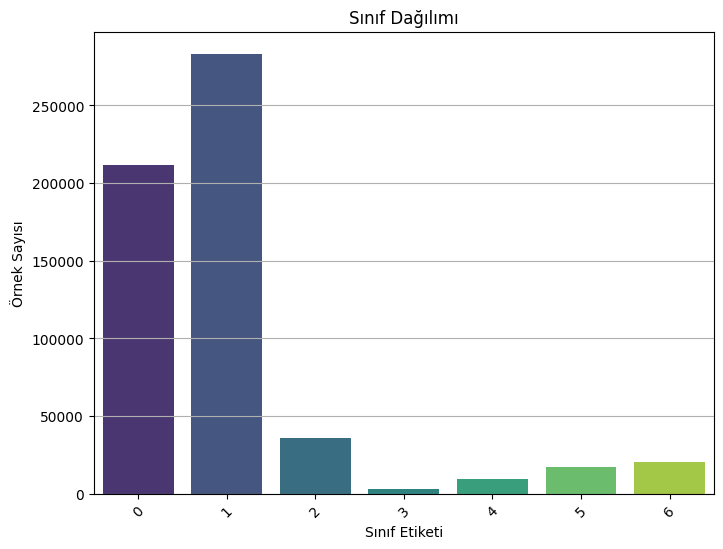

In [36]:
import pandas as pd

# Forest Cover Type veri setini yükle
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
data = pd.read_csv(url, header=None)

# Özellikler ve hedef değişkeni ayırma
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Hedef değişkeni 0 tabanlı hale getirelim
y = y - 1

# Veri seti hakkında genel bilgi
print("Veri Seti Hakkında Genel Bilgi:")
print(data.info())
print("\nİlk 5 Satır:\n", data.head())

# Özelliklerin ve hedef değişkenin boyutları
print(f"\nÖzelliklerin Sayısı: {X.shape[1]}")
print(f"Örnek Sayısı: {X.shape[0]}")
print(f"Hedef Değişken Sınıf Sayısı: {len(set(y))}")

# Hedef değişkenin sınıf dağılımı
print("\nSınıf Dağılımı:")
class_counts = pd.Series(y).value_counts()
print(class_counts)

# Sınıf dağılımını görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıf Etiketi')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

feature_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
] + [f"Wilderness_Area_{i}" for i in range(1, 5)] + [f"Soil_Type_{i}" for i in range(1, 41)]

In [41]:
# PSO ile özellik seçimi
pso = PSOFeatureSelection(X, y, feature_names)
selected_features, best_score, selected_feature_names = pso.optimize()
print(f"\nPSO En İyi Doğruluk: {best_score:.4f}")
print("PSO Seçilen Özellikler:", selected_feature_names)


Iteration 1/20

PSO En İyi Doğruluk: 0.8538
PSO Seçilen Özellikler:
- Elevation
- Slope
- Vertical_Distance_To_Hydrology
- Horizontal_Distance_To_Roadways
- Hillshade_9am
- Hillshade_3pm
- Horizontal_Distance_To_Fire_Points
- Wilderness_Area_2
- Wilderness_Area_3
- Wilderness_Area_4
- Soil_Type_3
- Soil_Type_5
- Soil_Type_8
- Soil_Type_9
- Soil_Type_10
- Soil_Type_12
- Soil_Type_13
- Soil_Type_14
- Soil_Type_16
- Soil_Type_17
- Soil_Type_19
- Soil_Type_20
- Soil_Type_21
- Soil_Type_26
- Soil_Type_28
- Soil_Type_32
- Soil_Type_33
- Soil_Type_35
- Soil_Type_37
- Soil_Type_38

Iteration 2/20

PSO En İyi Doğruluk: 0.8580
PSO Seçilen Özellikler:
- Elevation
- Aspect
- Slope
- Horizontal_Distance_To_Hydrology
- Horizontal_Distance_To_Roadways
- Hillshade_3pm
- Horizontal_Distance_To_Fire_Points
- Wilderness_Area_4
- Soil_Type_2
- Soil_Type_4
- Soil_Type_5
- Soil_Type_9
- Soil_Type_10
- Soil_Type_12
- Soil_Type_13
- Soil_Type_15
- Soil_Type_16
- Soil_Type_18
- Soil_Type_19
- Soil_Type_20
- S

In [43]:
# PCA ile özellik seçimi
n_components = 34
X_pca, variance_ratio = pca_feature_selection(X, n_components)
print(f"\nPCA Açıklanan Varyans Oranı: {sum(variance_ratio):.4f}")


PCA Açıklanan Varyans Oranı: 1.0000


In [44]:
# Veri setlerini ayırma
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_train_pso, X_test_pso, y_train, y_test = train_test_split(X[:, selected_features], y, test_size=0.3, random_state=42)

evaluator_pca = ModelEvaluator(X_train_pca, X_test_pca, y_train, y_test)
evaluator_pso = ModelEvaluator(X_train_pso, X_test_pso, y_train, y_test)


PCA ile XGBoost Performansı
XGBoost (PCA) Accuracy: 0.8904
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     63556
           1       0.88      0.92      0.90     85078
           2       0.92      0.93      0.93     10638
           3       0.90      0.86      0.88       795
           4       0.88      0.66      0.75      2941
           5       0.88      0.85      0.87      5227
           6       0.94      0.93      0.93      6069

    accuracy                           0.89    174304
   macro avg       0.90      0.86      0.88    174304
weighted avg       0.89      0.89      0.89    174304



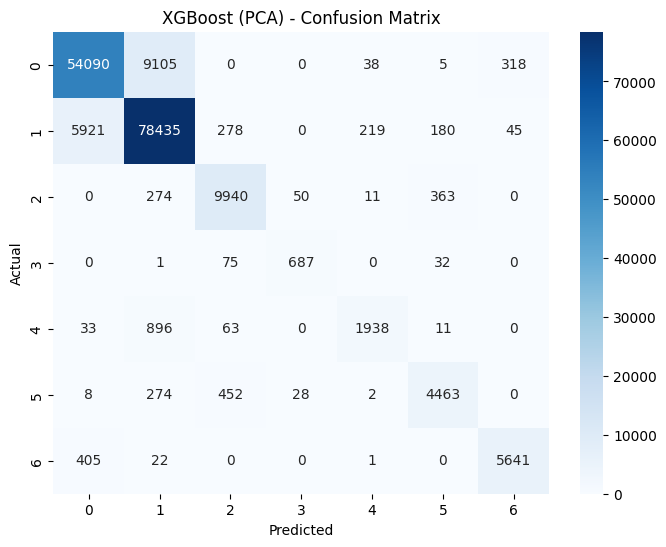

0.8903639618138425

In [45]:
# PCA ve PSO ile XGBoost Model Performansı
print("\nPCA ile XGBoost Performansı")
evaluator_pca.evaluate_model(XGBClassifier(tree_method='gpu_hist'), "XGBoost (PCA)")


PSO ile XGBoost Performansı
XGBoost (PSO) Accuracy: 0.8740
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     63556
           1       0.87      0.90      0.89     85078
           2       0.89      0.90      0.90     10638
           3       0.89      0.87      0.88       795
           4       0.88      0.58      0.70      2941
           5       0.84      0.80      0.82      5227
           6       0.93      0.90      0.91      6069

    accuracy                           0.87    174304
   macro avg       0.88      0.83      0.85    174304
weighted avg       0.87      0.87      0.87    174304



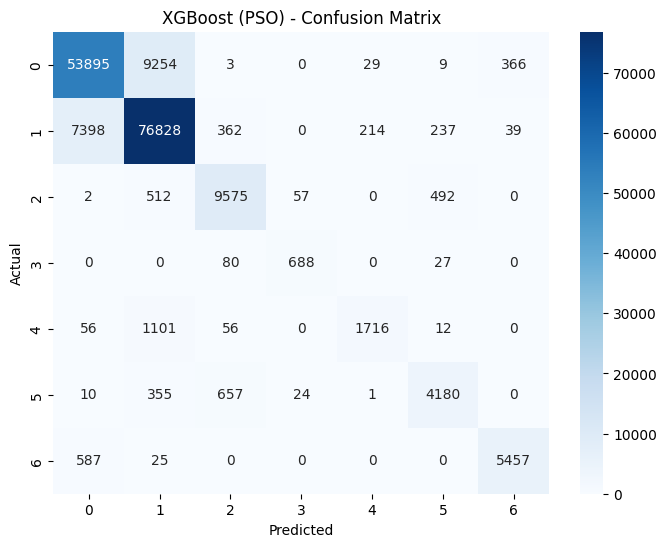

0.8739845327703323

In [46]:
print("\nPSO ile XGBoost Performansı")
evaluator_pso.evaluate_model(XGBClassifier(tree_method='gpu_hist'), "XGBoost (PSO)")